# Feeltrace and calibrated words analysis
Rubia Guerra

Last updated: Apr 14th 2022

## Module definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import signal
from statsmodels.tsa import stattools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

plt.style.use("seaborn")

%matplotlib inline

## Import data

In [2]:
def load_dataset(data_dir = '../EEG/data/p*'):
    feeltrace_data_files = glob.glob(os.path.join(data_dir, 'joystick.mat'))
    feeltrace_data_files.sort()
    
    feeltrace_data = []
    for subject_filename in feeltrace_data_files:
        mat_contents = sio.loadmat(subject_filename)
        df = pd.DataFrame(mat_contents['var'], columns=['Timestamps', 'Feeltrace'])
        p_number = re.findall('p\d+', subject_filename) * df.shape[0]
        df['p_number'] = p_number
        feeltrace_data.append(df)
    
    subject_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_calibrated_values.mat'))
    subject_data_files.sort()

    timestamps_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_time*.mat'))
    timestamps_data_files.sort()
    
    subjects_data = []
    for subject_filename, timestamp_filename in zip(subject_data_files, timestamps_data_files):
        subject_data = (sio.loadmat(subject_filename)['var'].ravel() + 10)*10
        timestamp_data = sio.loadmat(timestamp_filename)['var'].ravel()

        df_data = list(zip(timestamp_data, subject_data))        
        df = pd.DataFrame(df_data, columns=['Timestamps', 'Values'])

        p_number = re.findall('p\d+', subject_filename) * df.shape[0]
        df['p_number'] = p_number
        subjects_data.append(df)
    
    return subjects_data, feeltrace_data

In [3]:
[words_list, feeltrace_list] = load_dataset()

In [4]:
words_df = pd.concat(words_list)
feeltrace_df = pd.concat(feeltrace_list)

In [5]:
feeltrace_df.p_number.unique()

array(['p10', 'p12', 'p13', 'p15', 'p17', 'p19', 'p2', 'p20', 'p22',
       'p23', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'], dtype=object)

In [6]:
pd.concat(words_list).head()

,Timestamps,Values,p_number
0,41100,100.0,p10
1,66900,110.0,p10
2,86833,185.0,p10
3,109466,185.0,p10
4,152233,115.0,p10


In [7]:
pd.concat(feeltrace_list).head()

,Timestamps,Feeltrace,p_number
0,9437.0,74.0,p10
1,9451.0,74.0,p10
2,9471.0,74.0,p10
3,9511.0,75.0,p10
4,9548.0,74.0,p10


## Scratchpad

Testing code with a single subject

### Downsampling the continuous annotation

Before time series analysis can be performed, we must downsample the feeltrace to match the sample size of the interview words (or upsample the interview words):
- $\text{Fs}_{\text{feeltrace}} = 30$Hz
- $\text{Fs}_{\text{calibrated words}} \approx 0.05$Hz

In [8]:
def scale(X, min_=0, max_=200):
    return (X - min_)/(max_ - min_)

In [9]:
p10_words = words_list[0].copy()
p10_feeltrace = feeltrace_list[0].copy()

p10_words.Values = scale(p10_words.Values)
p10_feeltrace.Feeltrace = scale(p10_feeltrace.Feeltrace)

In [10]:
p10_words.Timestamps.count()/(p10_words.Timestamps.iloc[-1]*1e-3)

0.040934900303710546

In [11]:
p10_feeltrace.Timestamps.count()/(p10_feeltrace.Timestamps.iloc[-1]*1e-3)

29.64152332829802

Here, I attempt downsampling the feeltrace using aggregation strategies. I am using windows corresponding to midpoints in between sampled words. For instance, if the first interview word is recorded at $t=10$s and the next word is recorded at $t=15$s, the first window corresponds to $t=0$s to $t=12.5$s.

We can calculate windows using a rolling average on the interview timestamps.

In [12]:
timestamps = p10_words.Timestamps.rolling(2).mean().dropna().reset_index(drop=True)
timestamps.head()

0     54000.0
1     76866.5
2     98149.5
3    130849.5
4    158899.5
Name: Timestamps, dtype: float64

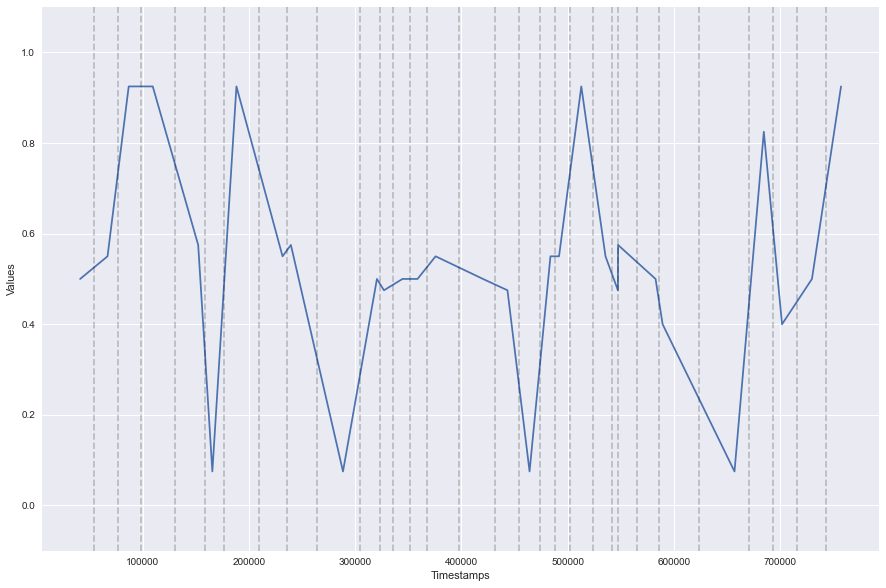

In [13]:
plt.figure(figsize=(15,10))
sns.lineplot(data=p10_words, x='Timestamps', y='Values')
plt.ylim([-.1, 1.1])

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

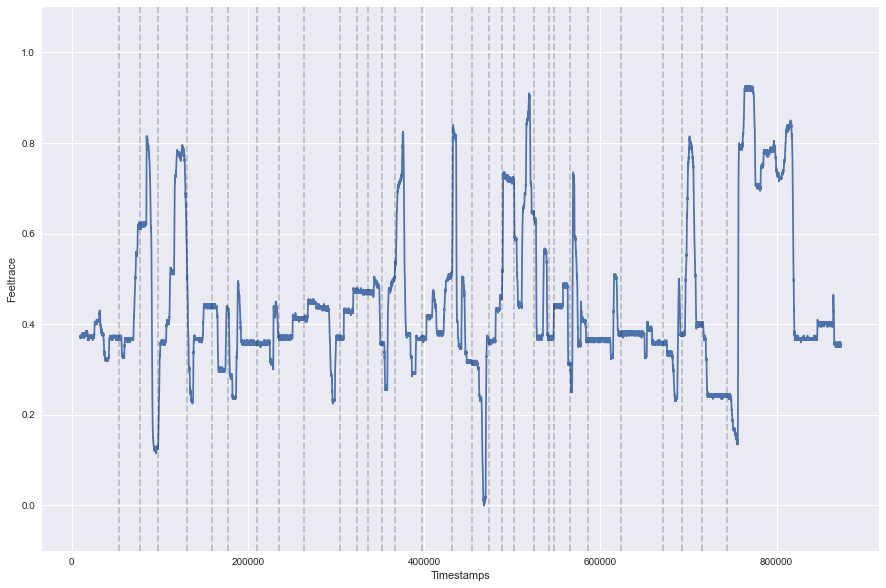

In [14]:
plt.figure(figsize=(15,10))
sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace')
plt.ylim([-.1, 1.1])

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

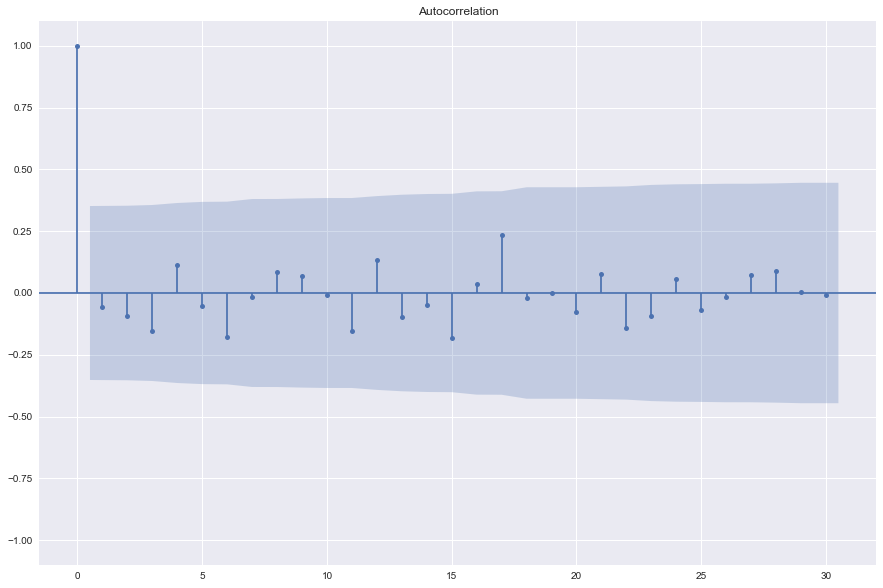

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc('figure', figsize=(15,10))
plot_acf(p10_words['Values'], lags=range(len(p10_words)))
plt.ylim([-1.1, 1.1]);

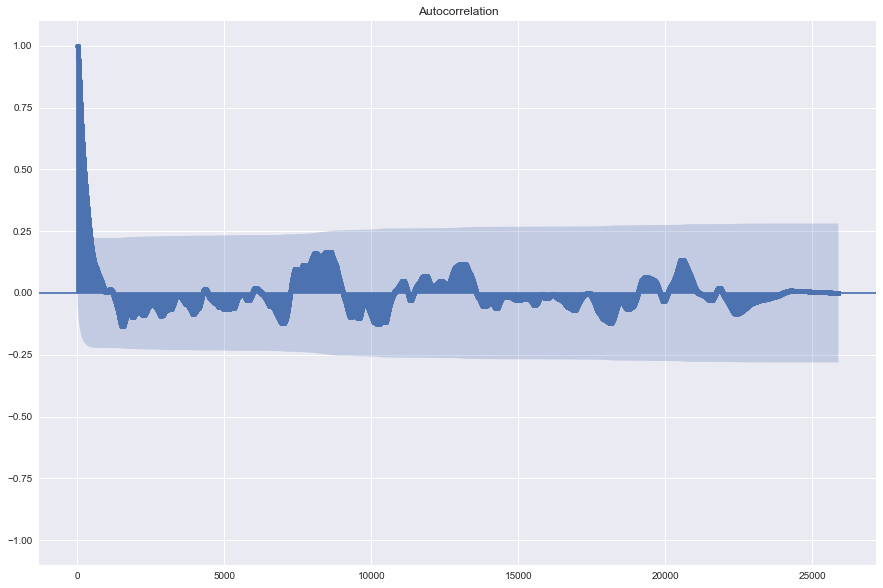

In [16]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace['Feeltrace'], lags=range(len(p10_feeltrace)))
plt.ylim([-1.1, 1.1]);

Extract indexes in the feeltrace by looking at the nearest timestamp that matches our window start points:

In [17]:
idxs = []

for timestamp in timestamps:
    arr = p10_feeltrace.Timestamps.to_numpy().astype(int)
    dist = (arr - timestamp)**2
    idx = tuple(np.argwhere(dist == np.min(dist))[0])
    idxs.append(idx[0])

print(f'Indexes: %s' % idxs)

Indexes: [1331, 2024, 2641, 3629, 4477, 5016, 6008, 6779, 7638, 8859, 9432, 9794, 10266, 10732, 11658, 12617, 13246, 13851, 14264, 14702, 15357, 15873, 16053, 16588, 17221, 18343, 19784, 20457, 21141, 21975]


Timestamps for the new feeltrace are defined as the mean timestamp of the window ((window start + window end) / 2):

In [18]:
feeltrace_timestamps = list(p10_feeltrace.loc[idxs, 'Timestamps'].rolling(2).mean().reset_index(drop=True))

# add first timestamp
feeltrace_timestamps[0] = p10_feeltrace.loc[idxs[0], 'Timestamps'] / 2

# add last timestamp
feeltrace_timestamps.append((p10_feeltrace.Timestamps.iloc[-1] + p10_feeltrace.loc[idxs[-1], 'Timestamps']) / 2)

feeltrace_timestamps = pd.Series(feeltrace_timestamps)

print(f'Timestamps (ms): %s' % feeltrace_timestamps.head())

Timestamps (ms): 0     26996.0
1     65427.0
2     87506.5
3    114499.5
4    144872.5
dtype: float64


In [19]:
# make sure both series are the same length
assert(len(feeltrace_timestamps) == len(p10_words.Timestamps))

Now, I explore aggregating the feeltrace in two ways:
- By taking the mean value of all points in window
- By calculating the overall direction of change in the feeltrace (slope)

#### Aggregating by taking the mean

In [20]:
p10_feeltrace_agg_mean = pd.DataFrame()

mean_feeltrace = []

# first window
mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[:idxs[0]].mean())

# middle windows
for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
    mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[prev_idx:idx].mean())

# last window
mean_feeltrace.append(p10_feeltrace.Feeltrace.loc[idxs[-1]:].mean())

# make sure both feeltrace and interview series are the same size
assert(len(mean_feeltrace) == len(p10_words.Values))

p10_feeltrace_agg_mean['Timestamps'] = feeltrace_timestamps
p10_feeltrace_agg_mean['Feeltrace'] = mean_feeltrace

In [21]:
p10_feeltrace_agg_mean.head()

,Timestamps,Feeltrace
0,26996.0,0.372654
1,65427.0,0.413613
2,87506.5,0.490906
3,114499.5,0.552672
4,144872.5,0.375592


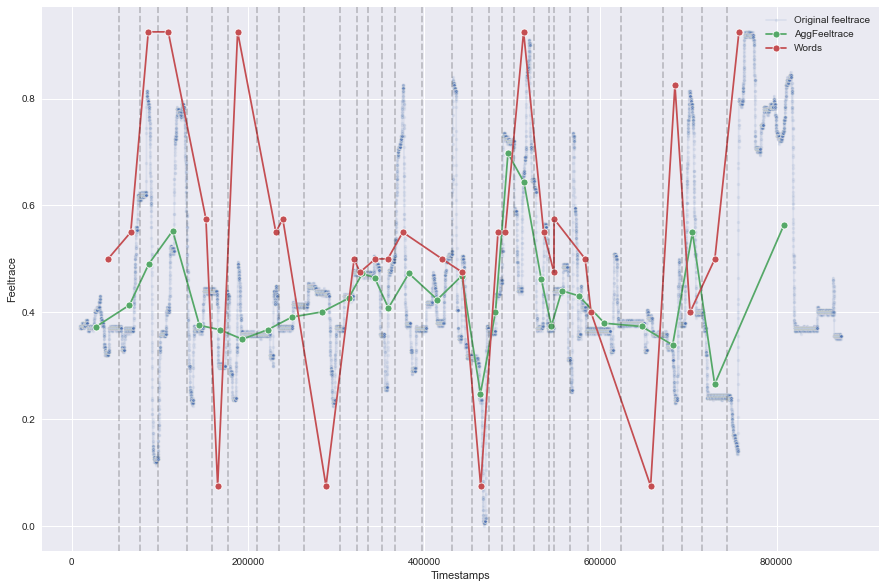

In [22]:
plt.figure(figsize=(15,10))

sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace', marker='.', alpha=0.1)
sns.lineplot(data=p10_feeltrace_agg_mean, x='Timestamps', y='Feeltrace', marker='o')
sns.lineplot(data=p10_words, x='Timestamps', y='Values', marker='o')
plt.legend(['Original feeltrace', 'AggFeeltrace', 'Words']);

for x in timestamps:
    plt.axvline(x, c='k', alpha=0.2, linestyle='dashed')

Checking autocorelation on aggregated data:

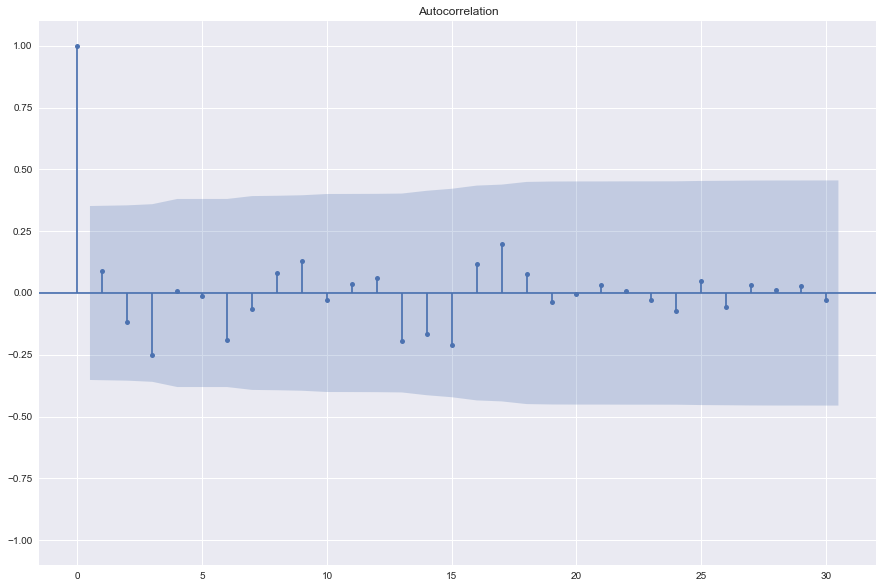

In [23]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace_agg_mean['Feeltrace'], lags=range(len(p10_feeltrace_agg_mean)))
plt.ylim([-1.1, 1.1]);

#### Aggregating by taking the slope

Trying to bin state transitions in three values:
- Increase in stress level (+1)
- Neutral (0)
- Decrease in stress level (-1)

Tried a few attemps, settling for taking first and last value of window:

In [24]:
def change_direction(x, y):
    def slope(x):
        slope = np.polyfit(range(len(x)), x, 1)[0]
        return slope
       
    def slope_angle(x, y):
        x = np.array(x)
        y = np.array(y)
        angle = np.arctan2(y[-1] - y[0], x[-1] - x[0])
        return angle
    
    def slope_sign(x, factor=1e3):
        if np.round(slope(x)*factor): 
            return np.sign(slope(x)*factor) 
        else: 
            return 0
        
    def first_last(x):
        diff = np.round(x.iloc[-1] - x.iloc[0],1)
        if diff:
            return np.sign(diff)
        else:
            return 0
       
    return first_last(x)

Calculating for feeltrace:

In [25]:
p10_feeltrace_agg_slope = pd.DataFrame()

slope_feeltrace = []

# first window
slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace[:idxs[0]], p10_feeltrace.Timestamps[:idxs[0]]))

# middle windows
for (prev_idx, idx) in zip(idxs[:-1], idxs[1:]):
    slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace.loc[prev_idx:idx], p10_feeltrace.Timestamps.loc[prev_idx:idx]))

# last window
slope_feeltrace.append(change_direction(p10_feeltrace.Feeltrace.loc[idxs[-1]:], p10_feeltrace.Timestamps.loc[idxs[-1]:]))

# make sure both feeltrace and interview series are the same size
assert(len(slope_feeltrace) == len(p10_words.Values))

p10_feeltrace_agg_slope['Timestamps'] = feeltrace_timestamps
p10_feeltrace_agg_slope['Feeltrace'] = slope_feeltrace
p10_feeltrace_agg_slope.head()

,Timestamps,Feeltrace
0,26996.0,0.0
1,65427.0,1.0
2,87506.5,-1.0
3,114499.5,1.0
4,144872.5,-1.0


Also calculating the slope values based on the aggregated feeltrace data:

In [26]:
p10_feeltrace_agg_mean_slope = pd.DataFrame()

mean_feeltrace_words = []
indexes = list(p10_feeltrace_agg_mean.index)

# middle windows
for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
    mean_feeltrace_words.append(change_direction(p10_feeltrace_agg_mean.Feeltrace.loc[prev_idx:idx], p10_feeltrace_agg_mean.Timestamps.loc[prev_idx:idx]))

p10_feeltrace_agg_mean_slope['Feeltrace'] = mean_feeltrace_words
p10_feeltrace_agg_mean_slope['Timestamps'] = timestamps
p10_feeltrace_agg_mean_slope.head()

,Feeltrace,Timestamps
0,0.0,54000.0
1,1.0,76866.5
2,1.0,98149.5
3,-1.0,130849.5
4,0.0,158899.5


Taking the slopes for interview words:

In [27]:
p10_words_agg_slope = pd.DataFrame()

slope_words = []
indexes = list(p10_words.index)

# middle windows
for (prev_idx, idx) in zip(indexes[:-1], indexes[1:]):
    slope_words.append(change_direction(p10_words.Values.loc[prev_idx:idx], p10_words.Timestamps.loc[prev_idx:idx]))

p10_words_agg_slope['Values'] = slope_words
p10_words_agg_slope['Timestamps'] = timestamps
p10_words_agg_slope.head()

,Values,Timestamps
0,1.0,54000.0
1,1.0,76866.5
2,0.0,98149.5
3,-1.0,130849.5
4,-1.0,158899.5


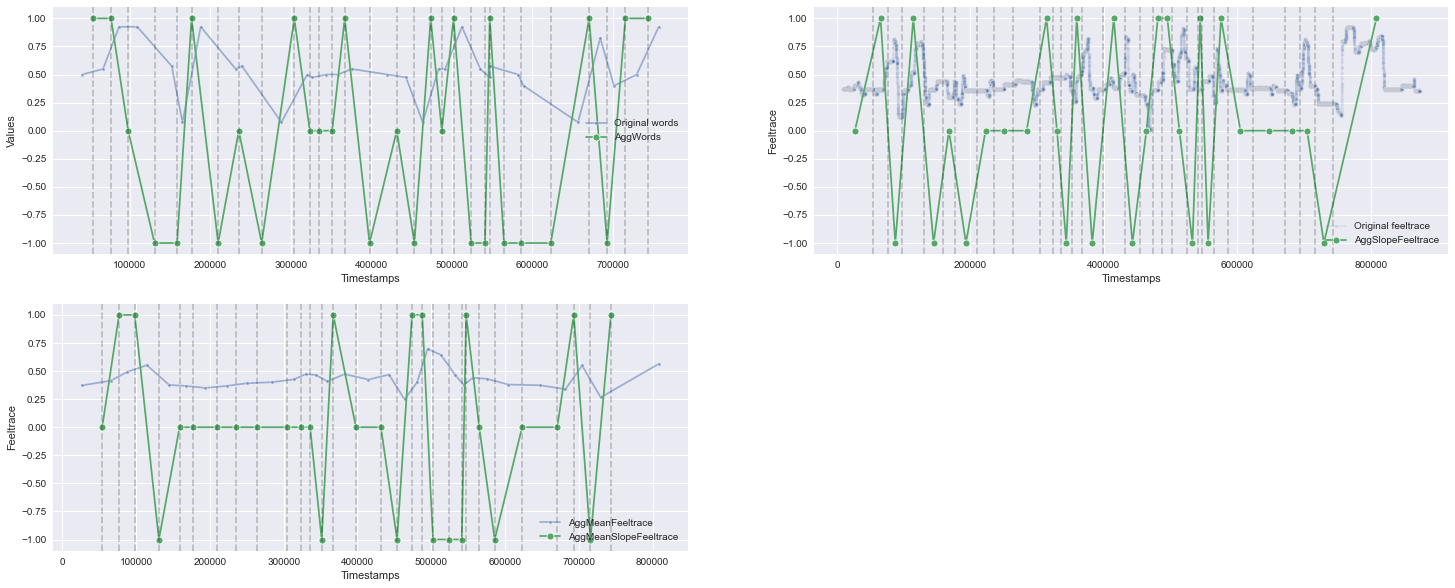

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(25,10))

sns.lineplot(data=p10_words, x='Timestamps', y='Values', marker='.', alpha=0.5, ax=axes[0,0])
sns.lineplot(data=p10_words_agg_slope, y='Values', x='Timestamps', marker='o', ax=axes[0,0]);
axes[0,0].legend(['Original words', 'AggWords']);

sns.lineplot(data=p10_feeltrace, x='Timestamps', y='Feeltrace', marker='.', alpha=0.1, ax=axes[0,1])
sns.lineplot(data=p10_feeltrace_agg_slope, y='Feeltrace', x='Timestamps', marker='o', ax=axes[0,1]);
axes[0,1].legend(['Original feeltrace', 'AggSlopeFeeltrace']);

sns.lineplot(data=p10_feeltrace_agg_mean, x='Timestamps', y='Feeltrace', marker='.', alpha=0.5, ax=axes[1,0])
sns.lineplot(data=p10_feeltrace_agg_mean_slope, y='Feeltrace', x='Timestamps', marker='o', ax=axes[1,0]);
axes[1,0].legend(['AggMeanFeeltrace', 'AggMeanSlopeFeeltrace']);

fig.delaxes(axes[1,1])

for x in timestamps:
    axes[0,0].axvline(x, c='k', alpha=0.2, linestyle='dashed')
    axes[0,1].axvline(x, c='k', alpha=0.2, linestyle='dashed')
    axes[1,0].axvline(x, c='k', alpha=0.2, linestyle='dashed')

To proceed with analysis, I will be comparing the transitions captured by word labels and by the aggregated feeltrace values.

In [29]:
p10_agg_data = pd.DataFrame()
p10_agg_data['Timestamps'] = p10_words_agg_slope['Timestamps'].copy()
p10_agg_data['Words'] = p10_words_agg_slope['Values'].copy()
p10_agg_data['Feeltrace'] = p10_feeltrace_agg_mean_slope['Feeltrace'].copy()

p10_agg_data.head()

,Timestamps,Words,Feeltrace
0,54000.0,1.0,0.0
1,76866.5,1.0,1.0
2,98149.5,0.0,1.0
3,130849.5,-1.0,-1.0
4,158899.5,-1.0,0.0


Checking autocorelation on aggregated data:

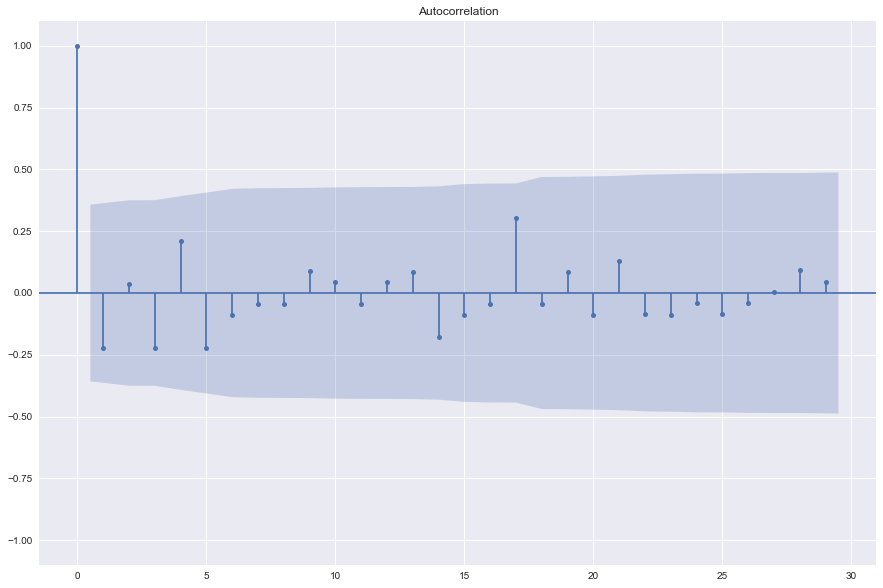

In [30]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_words_agg_slope['Values'], lags=range(len(p10_words_agg_slope)))
plt.ylim([-1.1, 1.1]);

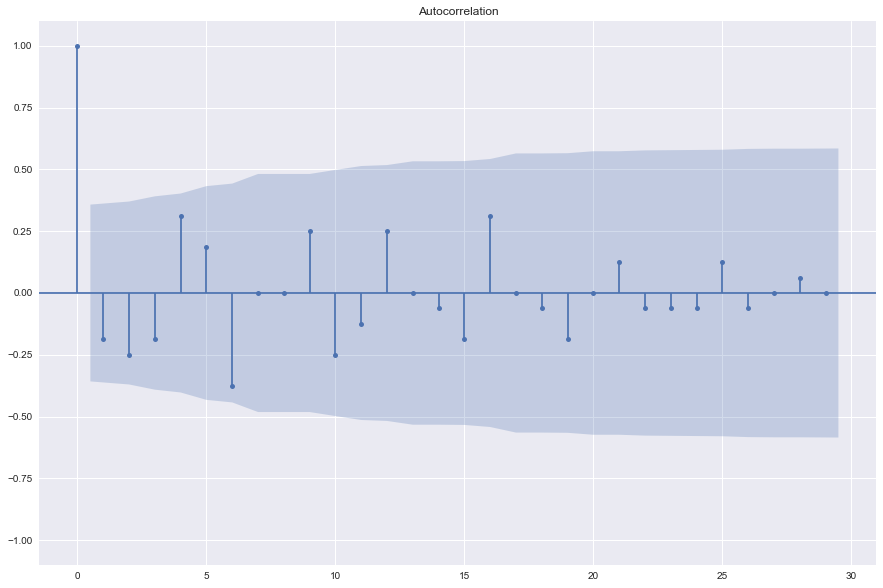

In [31]:
plt.rc('figure', figsize=(15,10))
plot_acf(p10_feeltrace_agg_mean_slope['Feeltrace'], lags=range(len(p10_feeltrace_agg_mean_slope)))
plt.ylim([-1.1, 1.1]);

#### Joint time series analysis

The results of Granger Causality for P10 are promising, suggeting a significant relationship* between interview words and feeltrace.

*(potentially a causality relationship, although this might be too strong of a claim, see `Limitations` section below)

In [32]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 8
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(p10_agg_data[['Words', 'Feeltrace']], variables = p10_agg_data[['Words', 'Feeltrace']].columns, verbose=True) 

# notes: 
# The row are the Response (Y) and the columns are the predictor series (X).

# For example, if you take the value 0.0021 in (row 1, column 2), it refers to 
# the p-value of Feeltrace_x causing Words_y.

Y = Words, X = Words, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = Feeltrace, X = Words, P Values = [0.0395, 0.1126, 0.0887, 0.1401, 0.1874, 0.3395, 0.0001, 0.0]
Y = Words, X = Feeltrace, P Values = [0.9161, 0.8378, 0.9315, 0.4438, 0.0869, 0.0579, 0.0188, 0.0021]
Y = Feeltrace, X = Feeltrace, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,Words_x,Feeltrace_x
Words_y,1.0,0.0021
Feeltrace_y,0.0,1.0000


#### Limitations

(see https://en.wikipedia.org/wiki/Granger_causality#Limitations)

As its name implies, Granger causality is not necessarily true causality. In fact, the Granger-causality tests fulfill only the Humean definition of causality that identifies the cause-effect relations with constant conjunctions.[14] If both X and Y are driven by a common third process with different lags, one might still fail to reject the alternative hypothesis of Granger causality. Yet, manipulation of one of the variables would not change the other. Indeed, the Granger-causality tests are designed to handle pairs of variables, and may produce misleading results when the true relationship involves three or more variables. Having said this, it has been argued that given a probabilistic view of causation, Granger causality can be considered true causality in that sense, especially when Reichenbach's "screening off" notion of probabilistic causation is taken into account.[15] Other possible sources of misguiding test results are: (1) not frequent enough or too frequent sampling, (2) nonlinear causal relationship, (3) time series nonstationarity and nonlinearity and (4) existence of rational expectations.[14] A similar test involving more variables can be applied with vector autoregression. Recently [16] a fundamental mathematical study of the mechanism underlying the Granger method has been provided. By making use exclusively of mathematical tools (Fourier transformation and differential calculus), it has been found that not even the most basic requirement underlying any possible definition of causality is met by the Granger causality test: any definition of causality should refer to the prediction of the future from the past; instead by inverting the time series it can be shown that Granger allows one to ”predict” the past from the future as well. 

In [33]:
#-----------------------------------------
# cointegration
#-----------------------------------------

# When two or more time series are cointegrated, it means they have a long run, 
# statistically significant relationship.

# This is the basic premise on which Vector Autoregression(VAR) models is based on. 
# So, it’s fairly common to implement the cointegration test before starting to 
# build VAR models.

# more technically:
# Order of integration(d) is nothing but the number of differencing required to 
# make a non-stationary time series stationary.

# Now, when you have two or more time series, and there exists a linear combination
#  of them that has an order of integration (d) less than that of the individual 
# series, then the collection of series is said to be cointegrated.

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(p10_agg_data[['Words', 'Feeltrace']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Words  ::  25.09     > 12.3212   =>   True
Feeltrace ::  5.58      > 4.1296    =>   True


In [34]:
from statsmodels.tsa.stattools import adfuller

#------------------------------
# check for stationarity
#-----------------------------

# VAR model requires the time series you want to forecast to be stationary, 
# it is customary to check all the time series in the system for stationarity.

# Since, differencing reduces the length of the series by 1 and since all the 
# time series has to be of the same length, you need to difference all the series
#  in the system if you choose to difference at all.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
        
 # ADF Test on each column
for name, column in p10_agg_data.iteritems():
    if 'Timestamps' in name:
        continue
    adfuller_test(column, name=column.name)
    print('\n')       

    Augmented Dickey-Fuller Test on "Words" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6022
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Feeltrace" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5379
 No. Lags Chosen       = 5
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.1065. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [35]:
p10_agg_data[['Words', 'Feeltrace']].corr()

,Words,Feeltrace
Words,1.000000,0.365165
Feeltrace,0.365165,1.000000


## Emotion dynamics analysis


### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

- **Emotional inertia:** refers to how well the intensity of an emotional state can be predicted from the emotional state at a previous moment.
- **Emotional instability:** refers to the magnitude of emotional changes from one moment to the next. An individual characterized by high levels of instability experiences larger emotional shifts from one moment to the next, resulting in a more unstable emotional life.
- **Emotional variability:** refers to the range or amplitude of someone’s emotional states across time. An individual characterized by higher levels of emotional variability experiences emotions that reach more extreme levels and shows larger emotional deviations from his or her average emotional level

In [36]:
class EmotionDynamics:
    def __init__(self, Fs=0.05, interval=300):
        self.lag = int(Fs*interval*1e-1) # feeltrace sampling rate x 300 ms

    def emotional_variability(self, X):
        return np.std(X)

    def emotional_instability(self, X):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
        return stattools.acf(X, nlags=lag)[lag] # Autocorrelation
    
    def get_parameters(self, X):
        X = np.array(X)
        parameters = {'Inertia':'', 'Instability':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotional_instability(X)
        parameters['Variability'] = self.emotional_variability(X)
        return parameters

In [37]:
ED = EmotionDynamics(Fs=0.05)
ED.get_parameters(p10_words['Values'])

{'Inertia': -0.058245294276545984,
 'Instability': 0.11847916666666665,
 'Variability': 0.23778154351203037}

In [38]:
words_data = []
for subject in words_list:
    calibrated_values = np.array(subject['Values'])
    ed = ED.get_parameters(calibrated_values)
    ed['p_number'] = subject['p_number'][0]
    ed['pass'] = 'interview'
    words_data.append(ed)
words_data = pd.DataFrame(words_data)
words_data.head()

,Inertia,Instability,Variability,p_number,pass
0,-0.058245,4739.166667,47.556309,p10,interview
1,-0.037667,4309.883721,45.126086,p12,interview
2,0.042847,4868.750000,49.910073,p13,interview
3,-0.182514,2575.000000,33.046305,p15,interview
4,0.240929,2970.967742,43.546121,p17,interview


In [39]:
ED = EmotionDynamics(Fs=30)
feeltrace_data = []
for subject in feeltrace_list:
    feeltrace = np.array(subject['Feeltrace'])
    ed = ED.get_parameters(feeltrace)
    ed['p_number'] = subject['p_number'][0]
    ed['pass'] = 'feeltrace'
    feeltrace_data.append(ed)
    
feeltrace_data = pd.DataFrame(feeltrace_data)
feeltrace_data.head()

,Inertia,Instability,Variability,p_number,pass
0,0.017359,0.593234,32.349176,p10,feeltrace
1,0.127506,1.278632,49.077727,p12,feeltrace
2,0.111697,0.951712,38.263004,p13,feeltrace
3,0.087622,1.989445,40.816129,p15,feeltrace
4,-0.005488,0.761333,42.022961,p17,feeltrace


In [40]:
X = pd.concat([words_data, feeltrace_data]).reset_index(drop=True)
X

,Inertia,Instability,Variability,p_number,pass
0,-0.058245,4739.166667,47.556309,p10,interview
1,-0.037667,4309.883721,45.126086,p12,interview
2,0.042847,4868.750000,49.910073,p13,interview
3,-0.182514,2575.000000,33.046305,p15,interview
4,0.240929,2970.967742,43.546121,p17,interview
5,0.205085,2337.096774,38.247434,p19,interview
6,0.079935,2387.777778,36.376685,p2,interview
7,-0.060902,3267.307692,39.285613,p20,interview
8,-0.079603,2957.500000,37.608064,p22,interview
9,0.009257,3268.243243,40.209157,p23,interview


### Data preprocessing: scaling
Standardize features by removing the mean and scaling to unit variance.

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [42]:
X_feeltrace = scaler.fit_transform(feeltrace_data[['Inertia', 'Instability', 'Variability']])
X_feeltrace = pd.DataFrame(X_feeltrace, columns=['Inertia', 'Instability', 'Variability'])
X_feeltrace['p_number'] = feeltrace_data['p_number']
X_feeltrace['pass'] = feeltrace_data['pass']
X_feeltrace

,Inertia,Instability,Variability,p_number,pass
0,-0.527612,-1.097853,-0.950685,p10,feeltrace
1,0.187769,0.930514,1.480287,p12,feeltrace
2,0.085095,-0.036975,-0.091295,p13,feeltrace
3,-0.071268,3.034094,0.279722,p15,feeltrace
4,-0.675998,-0.600382,0.455097,p17,feeltrace
5,-0.562169,1.039313,0.107712,p19,feeltrace
6,-0.202338,-0.738683,0.096802,p2,feeltrace
7,1.236198,-0.123969,-0.827949,p20,feeltrace
8,-1.526199,0.273190,-0.064174,p22,feeltrace
9,0.379056,-0.462175,-1.436566,p23,feeltrace


In [43]:
X_words = scaler.fit_transform(words_data[['Inertia', 'Instability', 'Variability']])
X_words = pd.DataFrame(X_words, columns=['Inertia', 'Instability', 'Variability'])
X_words['p_number'] = words_data['p_number']
X_words['pass'] = words_data['pass']
X_words

,Inertia,Instability,Variability,p_number,pass
0,-0.303855,1.091102,1.239767,p10,interview
1,-0.141110,0.697543,0.773963,p12,interview
2,0.495656,1.209901,1.690916,p13,interview
3,-1.286661,-0.892967,-1.541383,p15,interview
4,2.062228,-0.529951,0.471130,p17,interview
5,1.778744,-1.111073,-0.544476,p19,interview
6,0.788972,-1.064609,-0.903045,p2,interview
7,-0.324868,-0.258272,-0.345487,p20,interview
8,-0.472769,-0.542298,-0.667025,p22,interview
9,0.230004,-0.257414,-0.168470,p23,interview


In [44]:
X_scaled = pd.concat([X_words, X_feeltrace]).reset_index(drop=True)

### Pairplot analysis

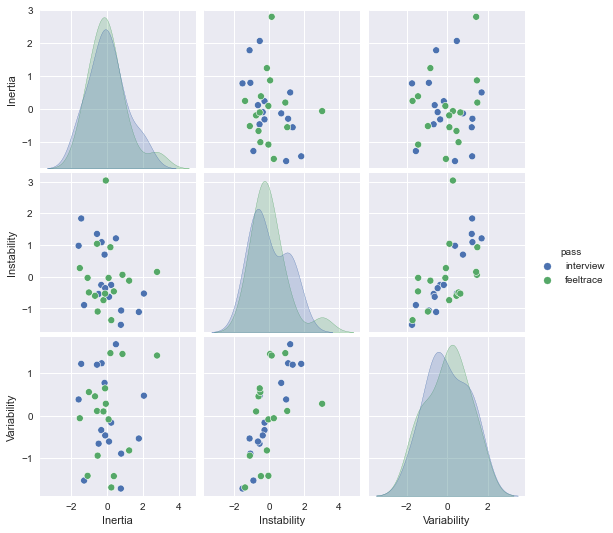

In [45]:
sns.pairplot(X_scaled, hue='pass');

In [46]:
abs(X_feeltrace[['Inertia', 'Instability', 'Variability']] - X_words[['Inertia', 'Instability', 'Variability']])

,Inertia,Instability,Variability
0,0.223757,2.188955,2.190452
1,0.328879,0.232971,0.706323
2,0.410561,1.246877,1.782211
3,1.215394,3.927061,1.821105
4,2.738226,0.070431,0.016032
5,2.340913,2.150386,0.652188
6,0.991310,0.325926,0.999847
7,1.561066,0.134303,0.482461
8,1.053430,0.815489,0.602851
9,0.149052,0.204760,1.268096


### 3D scatterplot

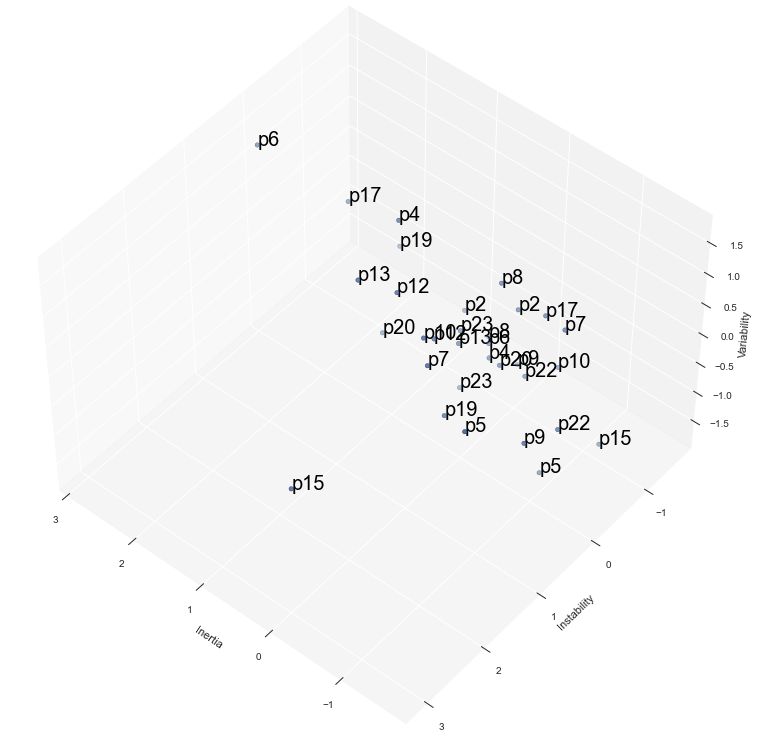

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)

ax.scatter(X_scaled.Inertia, X_scaled.Instability, X_scaled.Variability, cmap=plt.cm.nipy_spectral, edgecolor="k")

for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=20, zorder=1,  
    color='k') 

ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.show()

### Principal Component Analysis

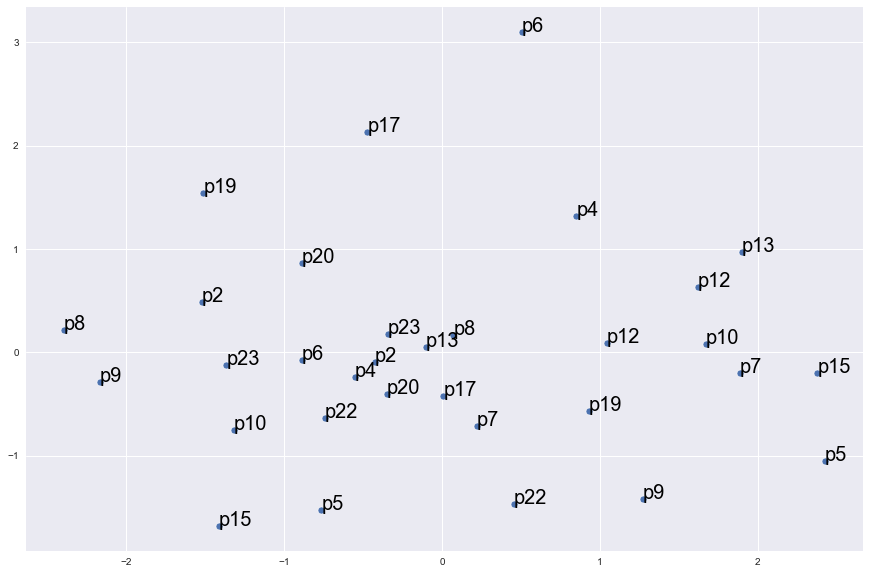

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
X_PCA = pca.transform(X_scaled[['Inertia', 'Instability', 'Variability']])

sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1]);

for i, (_, subject) in enumerate(X_scaled.iterrows()): #plot each point + it's index as text above
    label = subject['p_number']
    plt.text(X_PCA[i, 0], X_PCA[i, 1],  '%s' % label, size=20, zorder=1,  
    color='k') 

### Gaussian Mixture Model

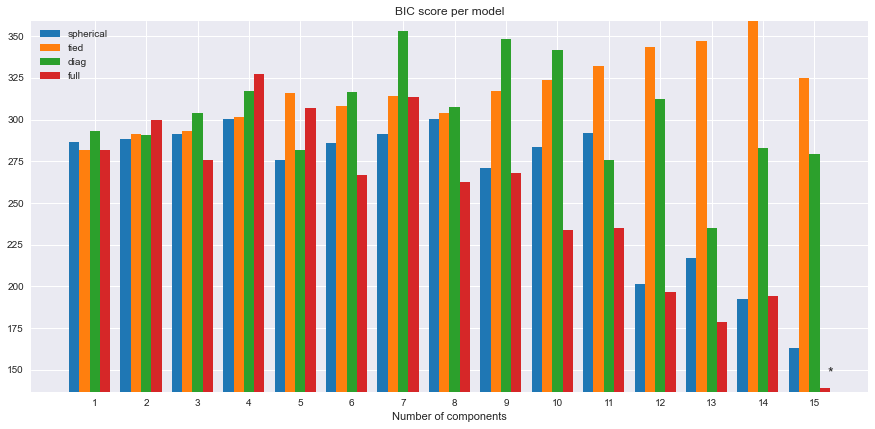

In [49]:
"""
================================
Gaussian Mixture Model Selection
================================

Gaussian Mixture Models using information-theoretic criteria (BIC).
Model selection concerns both the covariance type and the number of components in the model.
Unlike Bayesian procedures, such inferences are prior-free.

"""

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 16)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
        bic.append(gmm.bic(X_scaled[['Inertia', 'Instability', 'Variability']]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 15))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types);

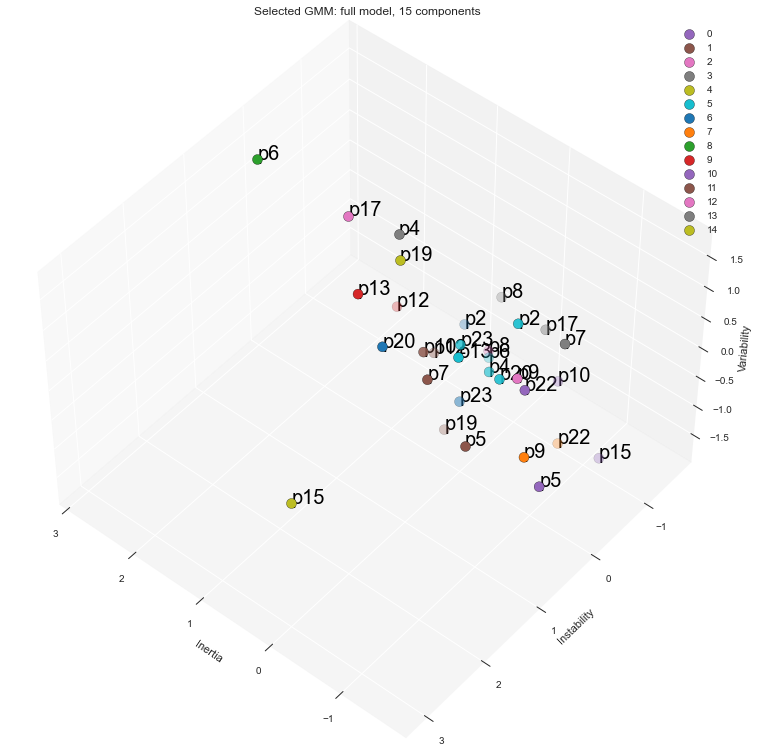

In [50]:
# Plot the winner
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)
Y_ = clf.predict(X_scaled[['Inertia', 'Instability', 'Variability']])

for i, (mean, color) in enumerate(zip(clf.means_, color_iter)):
    if not np.any(Y_ == i):
        continue
    ax.scatter(X_scaled.Inertia.loc[Y_ == i], X_scaled.Instability.loc[Y_ == i], 
               X_scaled.Variability.loc[Y_ == i], s=100, color=color, edgecolor="k")

for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=20, zorder=1,  
    color='k') 
    
plt.legend(range(len(clf.means_)))
ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)


plt.show()